# Part 3: From Data to Decisions - Exploration & Statistics

---

## Learning Objectives

This notebook demonstrates **Module 2-3: Understanding Your Data**

> Extract meaningful insights and identify patterns that drive decisions

You'll learn to:
- Visualize trends and patterns
- Identify seasonality and correlations
- Conduct statistical validation
- Discover key drivers of sales
- Create story-ready visualizations

**The Goal**: Transform clean data into actionable business insights.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../utils')
from helpers import set_plot_style

set_plot_style()

print("Libraries loaded successfully")

Libraries loaded successfully


## Load Cleaned Data

In [2]:
# Load sample dataset for faster exploration
df = pd.read_csv('../data/processed/sales_cleaned_sample.csv', parse_dates=['date'])

print(f"Loaded {df.shape[0]:,} sales records")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Stores: {df['store_nbr'].nunique()}")
print(f"Product families: {df['family'].nunique()}")

df.head()

Loaded 42,100 sales records
Date range: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
Stores: 5
Product families: 5


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,month,day,day_of_week,day_name,week_of_year,quarter,is_weekend,is_month_start,is_month_end,has_sales
0,729,2013-01-01,3,BEVERAGES,0.0,0,Quito,Pichincha,D,8,...,1,1,1,Tuesday,1,1,0,1,0,0
1,733,2013-01-01,3,CLEANING,0.0,0,Quito,Pichincha,D,8,...,1,1,1,Tuesday,1,1,0,1,0,0
2,734,2013-01-01,3,DAIRY,0.0,0,Quito,Pichincha,D,8,...,1,1,1,Tuesday,1,1,0,1,0,0
3,738,2013-01-01,3,GROCERY I,0.0,0,Quito,Pichincha,D,8,...,1,1,1,Tuesday,1,1,0,1,0,0
4,756,2013-01-01,3,PRODUCE,0.0,0,Quito,Pichincha,D,8,...,1,1,1,Tuesday,1,1,0,1,0,0


## 1. Sales Trends Over Time

### Overall Sales Pattern

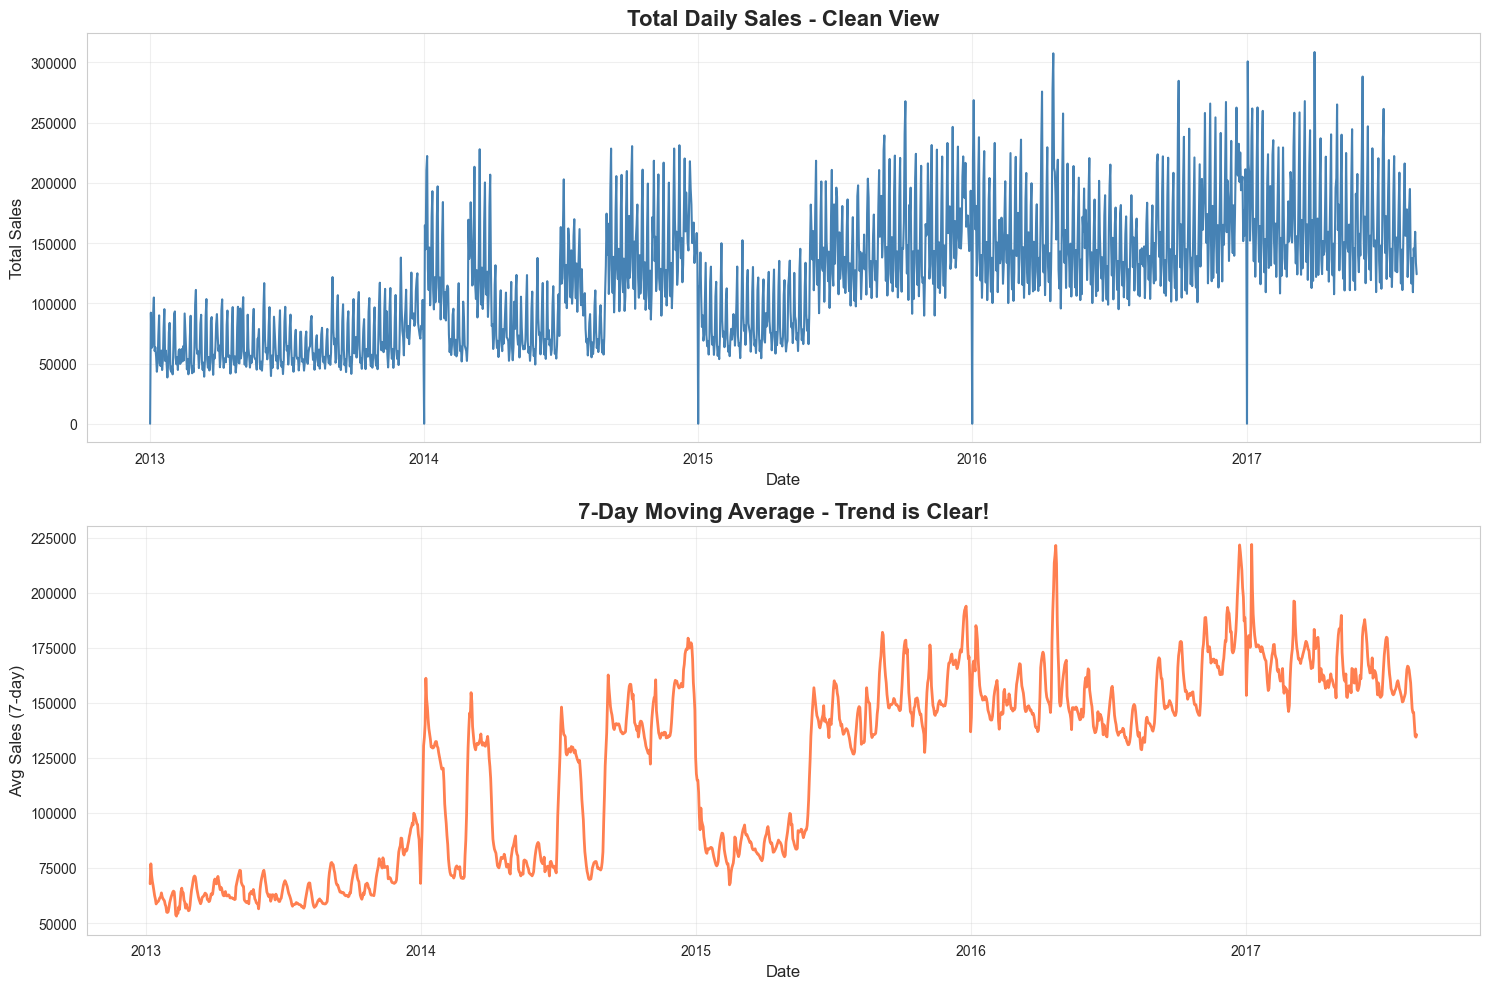

Insight: Notice the upward trend and regular patterns


In [3]:
daily_sales = df.groupby('date')['sales'].sum().reset_index()

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Daily sales
axes[0].plot(daily_sales['date'], daily_sales['sales'], linewidth=1.5, color='steelblue')
axes[0].set_title('Total Daily Sales - Clean View', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Total Sales')
axes[0].grid(alpha=0.3)

# 7-day rolling average
daily_sales['sales_ma7'] = daily_sales['sales'].rolling(window=7).mean()
axes[1].plot(daily_sales['date'], daily_sales['sales_ma7'], linewidth=2, color='coral')
axes[1].set_title('7-Day Moving Average - Trend is Clear!', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Avg Sales (7-day)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Insight: Notice the upward trend and regular patterns")

### Monthly Sales Patterns

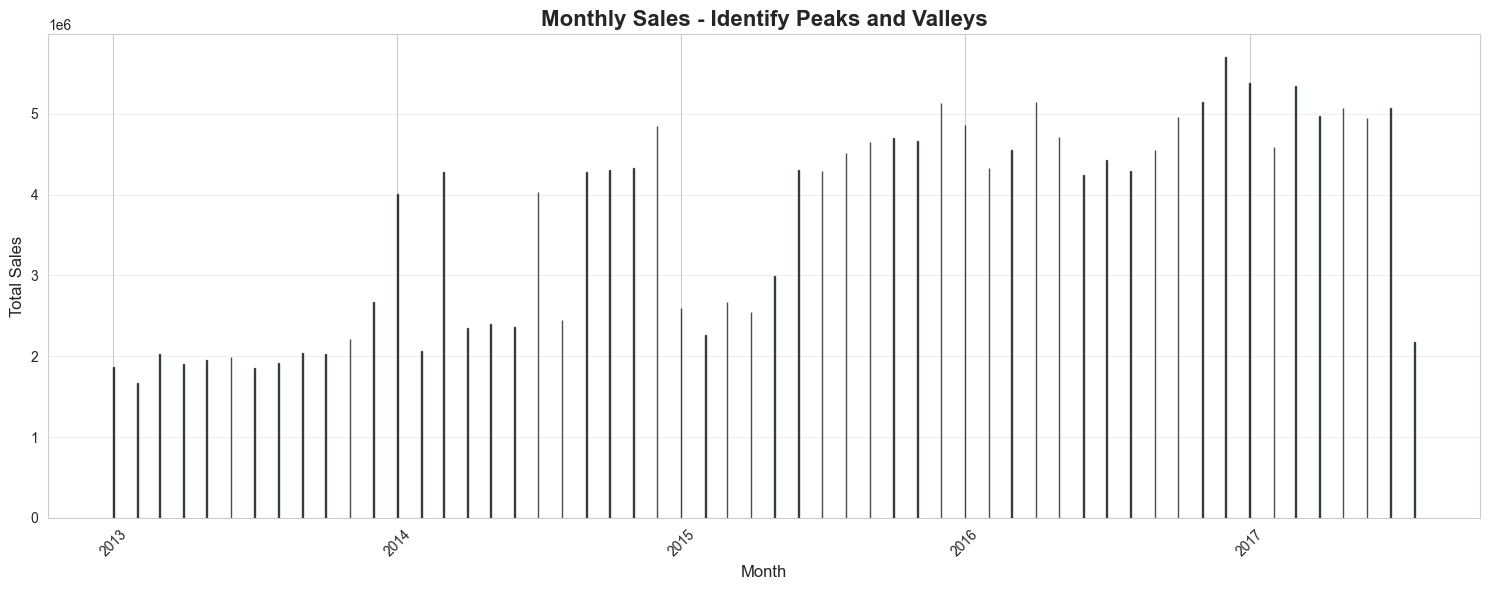

Top 5 Sales Months:
   year_month         sales
47 2016-12-01  5.695689e+06
48 2017-01-01  5.383296e+06
50 2017-03-01  5.345120e+06
39 2016-04-01  5.150203e+06
46 2016-11-01  5.139249e+06


In [4]:
monthly_sales = df.groupby(['year', 'month'])['sales'].sum().reset_index()
monthly_sales['year_month'] = pd.to_datetime(monthly_sales[['year', 'month']].assign(day=1))

plt.figure(figsize=(15, 6))
plt.bar(monthly_sales['year_month'], monthly_sales['sales'], color='teal', alpha=0.7, edgecolor='black')
plt.title('Monthly Sales - Identify Peaks and Valleys', fontsize=16, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Find peak months
top_months = monthly_sales.nlargest(5, 'sales')
print(f"Top 5 Sales Months:")
print(top_months[['year_month', 'sales']])

## 2. Seasonality Analysis

### Day of Week Patterns

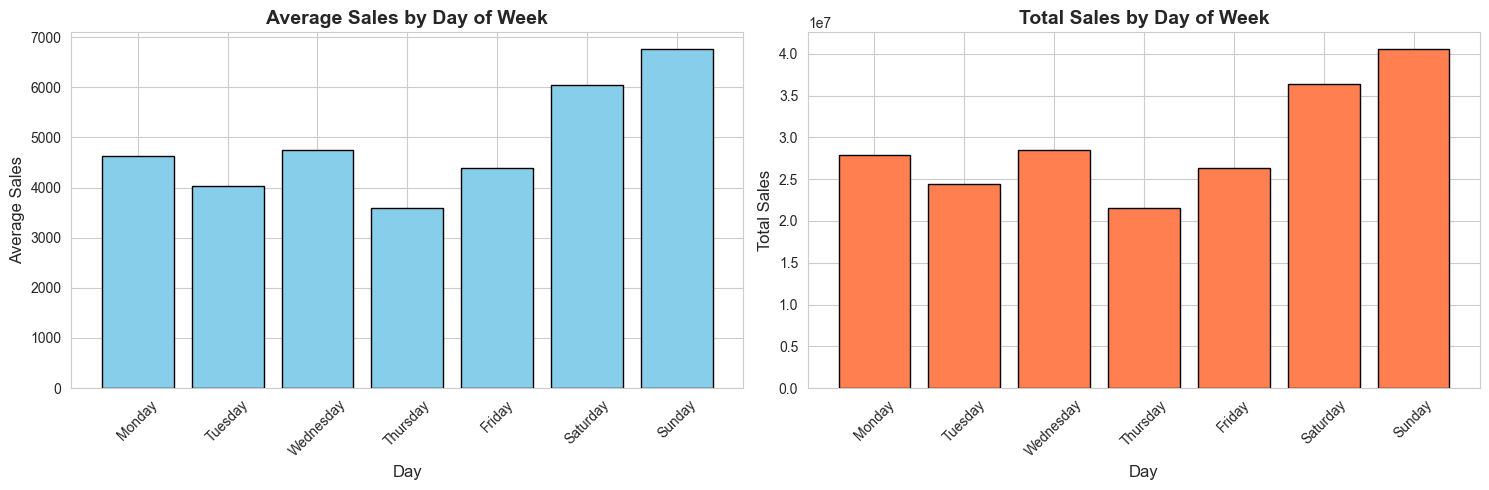

Insight: Weekends vs Weekdays - Clear patterns for inventory planning


In [5]:
dow_sales = df.groupby('day_name')['sales'].agg(['mean', 'sum']).reset_index()

# Sort by weekday order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_sales['day_name'] = pd.Categorical(dow_sales['day_name'], categories=day_order, ordered=True)
dow_sales = dow_sales.sort_values('day_name')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Average sales by day
axes[0].bar(dow_sales['day_name'], dow_sales['mean'], color='skyblue', edgecolor='black')
axes[0].set_title('Average Sales by Day of Week', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Day')
axes[0].set_ylabel('Average Sales')
axes[0].tick_params(axis='x', rotation=45)

# Total sales by day
axes[1].bar(dow_sales['day_name'], dow_sales['sum'], color='coral', edgecolor='black')
axes[1].set_title('Total Sales by Day of Week', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Total Sales')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"Insight: Weekends vs Weekdays - Clear patterns for inventory planning")

### Monthly Seasonality

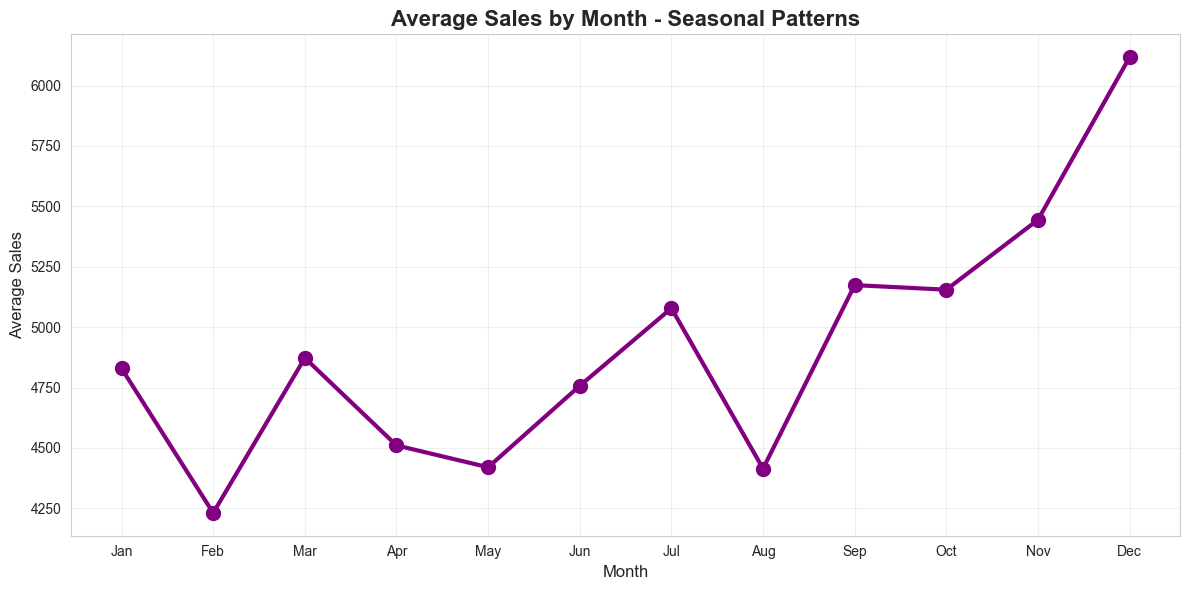

Peak sales month: Month 12
Lowest sales month: Month 2


In [6]:
month_sales = df.groupby('month')['sales'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(month_sales['month'], month_sales['sales'], marker='o', linewidth=3, 
markersize=10, color='purple')
plt.title('Average Sales by Month - Seasonal Patterns', fontsize=16, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

peak_month = month_sales.loc[month_sales['sales'].idxmax(), 'month']
low_month = month_sales.loc[month_sales['sales'].idxmin(), 'month']
print(f"Peak sales month: Month {peak_month}")
print(f"Lowest sales month: Month {low_month}")

## 3. Store and Product Analysis

### Top Performing Stores

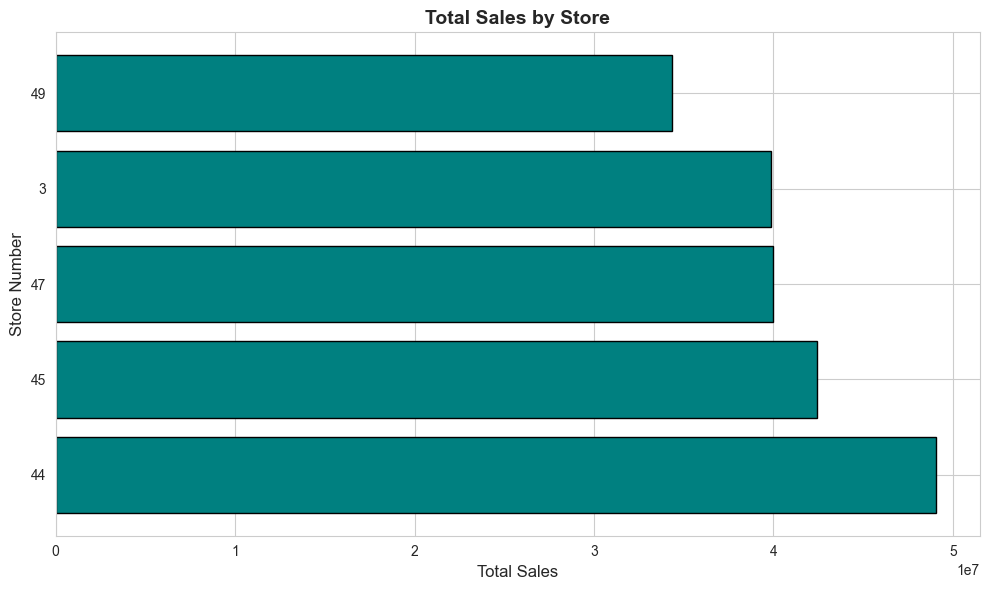

Top 3 Stores:
   store_nbr   total_sales    avg_sales  num_records
1         44  4.905619e+07  5826.150418         8420
2         45  4.240168e+07  5035.829376         8420
3         47  3.995305e+07  4745.017774         8420


In [7]:
store_performance = df.groupby('store_nbr').agg({
'sales': ['sum', 'mean', 'count']
}).reset_index()
store_performance.columns = ['store_nbr', 'total_sales', 'avg_sales', 'num_records']
store_performance = store_performance.sort_values('total_sales', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(store_performance['store_nbr'].astype(str), store_performance['total_sales'], 
color='teal', edgecolor='black')
plt.title('Total Sales by Store', fontsize=14, fontweight='bold')
plt.xlabel('Total Sales')
plt.ylabel('Store Number')
plt.tight_layout()
plt.show()

print(f"Top 3 Stores:")
print(store_performance.head(3))

### Product Family Performance

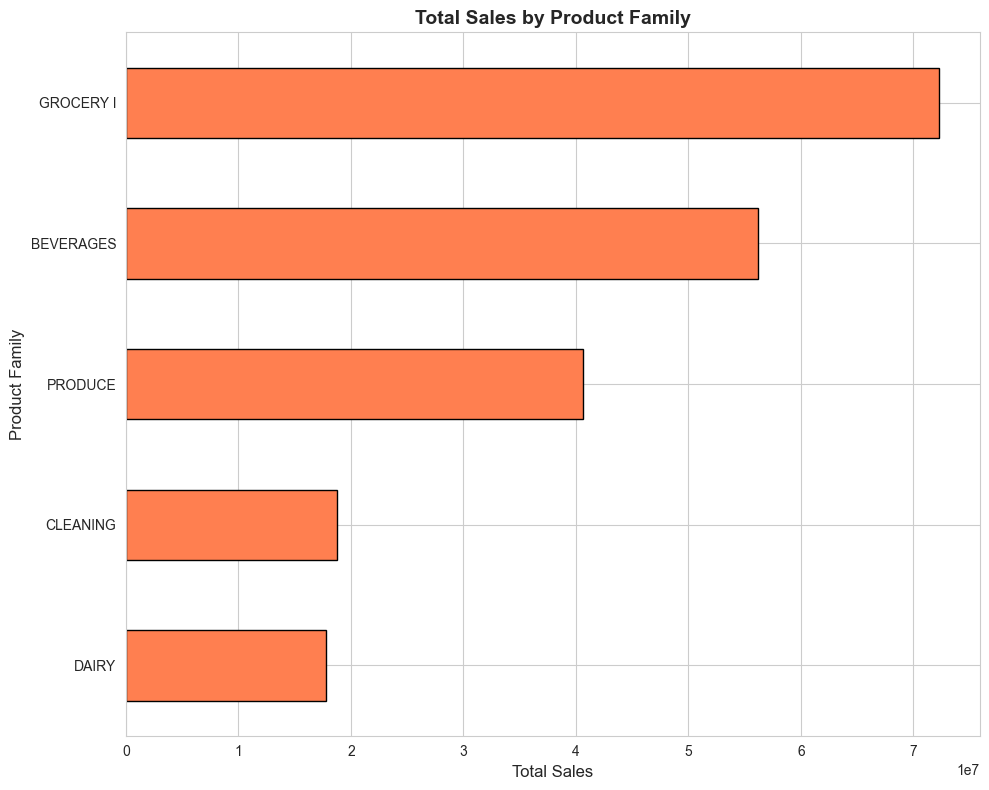

Top Product Family:
GROCERY I: 72,308,783


In [8]:
family_sales = df.groupby('family')['sales'].sum().sort_values(ascending=True)

plt.figure(figsize=(10, 8))
family_sales.plot(kind='barh', color='coral', edgecolor='black')
plt.title('Total Sales by Product Family', fontsize=14, fontweight='bold')
plt.xlabel('Total Sales')
plt.ylabel('Product Family')
plt.tight_layout()
plt.show()

print(f"Top Product Family:")
print(f"{family_sales.index[-1]}: {family_sales.iloc[-1]:,.0f}")

## 4. Statistical Analysis

### Correlation Analysis

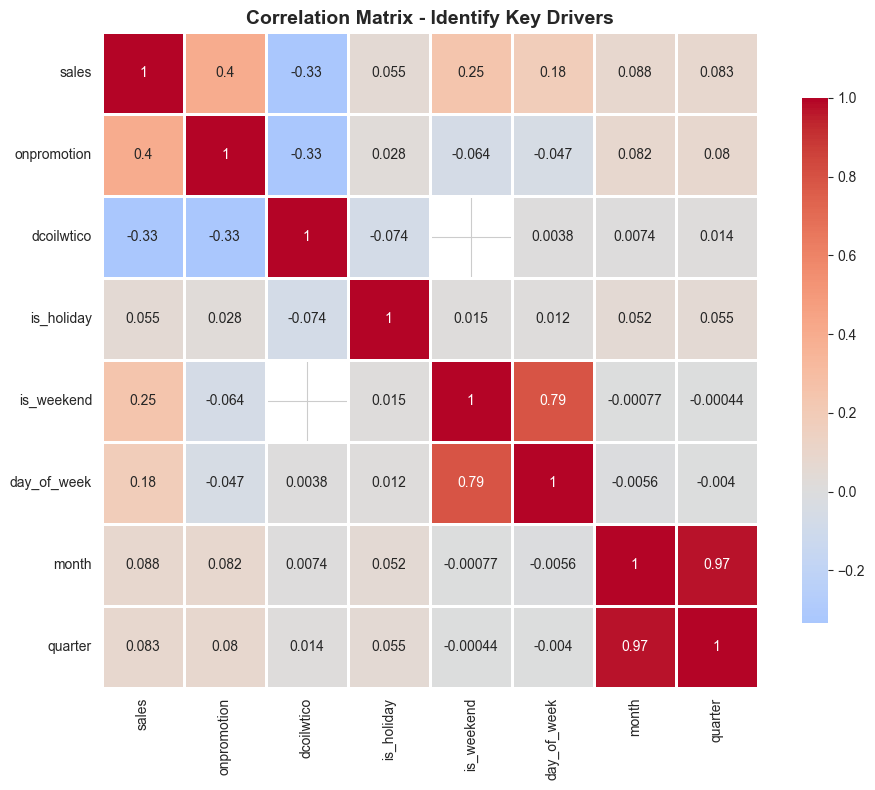

Correlations with Sales:
sales          1.000000
onpromotion    0.400522
is_weekend     0.245561
day_of_week    0.184454
month          0.088204
quarter        0.082992
is_holiday     0.055308
dcoilwtico    -0.332671
Name: sales, dtype: float64


In [9]:
# Select numeric columns for correlation
numeric_cols = ['sales', 'onpromotion', 'dcoilwtico', 'is_holiday', 'is_weekend', 
'day_of_week', 'month', 'quarter']
corr_data = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0, 
square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Identify Key Drivers', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Find strongest correlations with sales
sales_corr = corr_data['sales'].sort_values(ascending=False)
print(f"Correlations with Sales:")
print(sales_corr)

### Promotion Impact Analysis

Promotion Impact:
     onpromotion          mean     median  count  promotion_status
0              0   3383.481788   2302.000  17321  Not On Promotion
1              1   4443.529427   3286.500   2872      On Promotion
2              2   3921.314371   2701.000   2186      On Promotion
3              3   4087.269978   2762.000   1863      On Promotion
4              4   4536.814844   2926.000   1395      On Promotion
..           ...           ...        ...    ...               ...
244          248  12169.133000  12169.133      1      On Promotion
245          249  12377.413000  12377.413      2      On Promotion
246          250  12231.239000  12231.239      1      On Promotion
247          251  10599.315667  10461.010      3      On Promotion
248          252  11089.586000  11089.586      1      On Promotion

[249 rows x 5 columns]


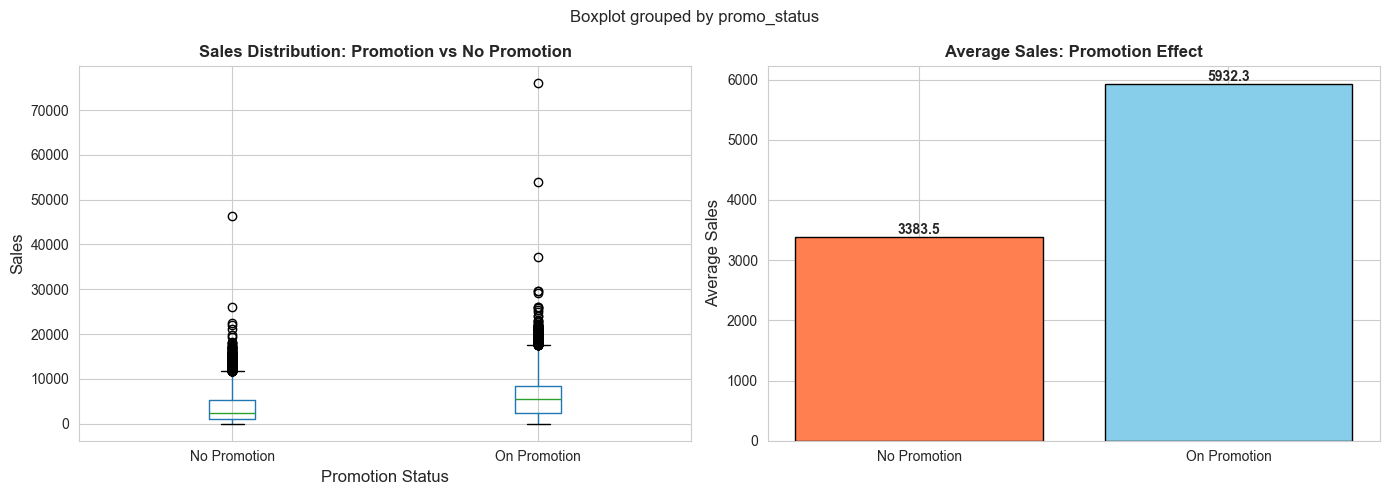

Statistical Test (T-test):
T-statistic: 69.6339
P-value: 0.000000
Result: Promotions have a STATISTICALLY SIGNIFICANT impact on sales!


In [10]:
promo_impact = df.groupby('onpromotion')['sales'].agg(['mean', 'median', 'count']).reset_index()
promo_impact['promotion_status'] = promo_impact['onpromotion'].apply(
lambda x: 'On Promotion' if x > 0 else 'Not On Promotion'
)

print(f"Promotion Impact:")
print(promo_impact)

# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
df['promo_status'] = df['onpromotion'].apply(lambda x: 'On Promotion' if x > 0 else 'No Promotion')
df.boxplot(column='sales', by='promo_status', ax=axes[0])
axes[0].set_title('Sales Distribution: Promotion vs No Promotion', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Promotion Status')
axes[0].set_ylabel('Sales')
plt.sca(axes[0])
plt.xticks(rotation=0)

# Bar plot of averages
avg_sales = df.groupby('promo_status')['sales'].mean()
axes[1].bar(avg_sales.index, avg_sales.values, color=['coral', 'skyblue'], edgecolor='black')
axes[1].set_title('Average Sales: Promotion Effect', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average Sales')

for i, v in enumerate(avg_sales.values):
    axes[1].text(i, v, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Statistical test
promo_sales = df[df['onpromotion'] > 0]['sales']
no_promo_sales = df[df['onpromotion'] == 0]['sales']

t_stat, p_value = stats.ttest_ind(promo_sales, no_promo_sales)
print(f"Statistical Test (T-test):")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.6f}")

if p_value < 0.05:
    print("Result: Promotions have a STATISTICALLY SIGNIFICANT impact on sales!")
else:
    print("Result: No significant difference detected")

### Holiday Impact

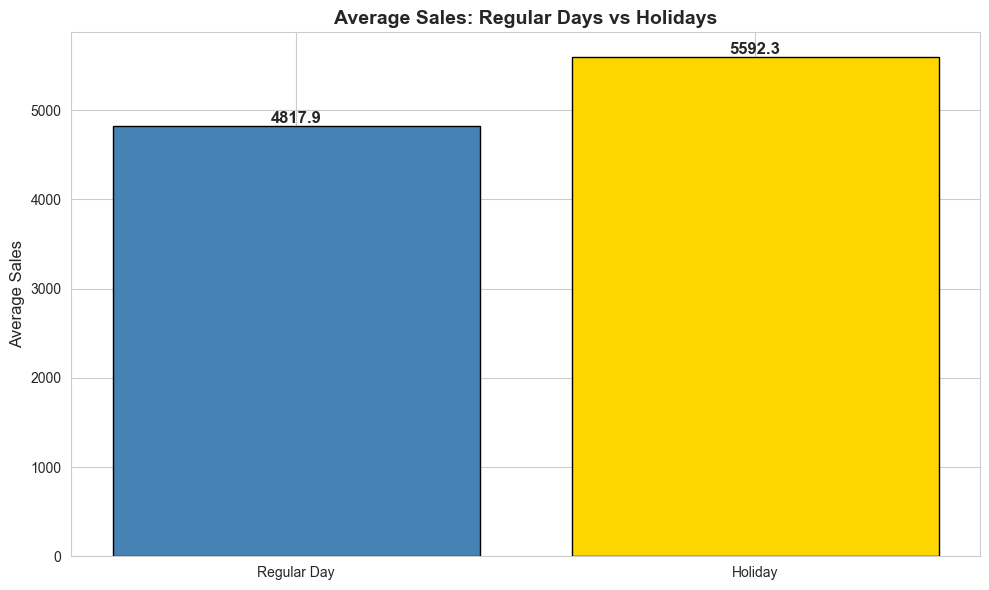

Holiday Impact:
   is_holiday    avg_sales  median_sales  count holiday_label
0           0  4817.912324        3415.0  38525   Regular Day
1           1  5592.252189        4069.0   3575       Holiday
T-test Result: p-value = 0.000000
Holidays have SIGNIFICANT impact on sales


In [11]:
holiday_impact = df.groupby('is_holiday').agg({
'sales': ['mean', 'median', 'count']
}).reset_index()
holiday_impact.columns = ['is_holiday', 'avg_sales', 'median_sales', 'count']
holiday_impact['holiday_label'] = holiday_impact['is_holiday'].map({0: 'Regular Day', 1: 'Holiday'})

plt.figure(figsize=(10, 6))
plt.bar(holiday_impact['holiday_label'], holiday_impact['avg_sales'], 
color=['steelblue', 'gold'], edgecolor='black')
plt.title('Average Sales: Regular Days vs Holidays', fontsize=14, fontweight='bold')
plt.ylabel('Average Sales')

for i, row in holiday_impact.iterrows():
    plt.text(i, row['avg_sales'], f"{row['avg_sales']:.1f}", 
    ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Holiday Impact:")
print(holiday_impact)

# Statistical test
holiday_sales = df[df['is_holiday'] == 1]['sales']
regular_sales = df[df['is_holiday'] == 0]['sales']

t_stat, p_value = stats.ttest_ind(holiday_sales, regular_sales)
print(f"T-test Result: p-value = {p_value:.6f}")
if p_value < 0.05:
    print("Holidays have SIGNIFICANT impact on sales")
else:
    print("No significant holiday effect detected")

## 5. Oil Price Impact

Ecuador is oil-dependent - does oil price affect consumer spending?

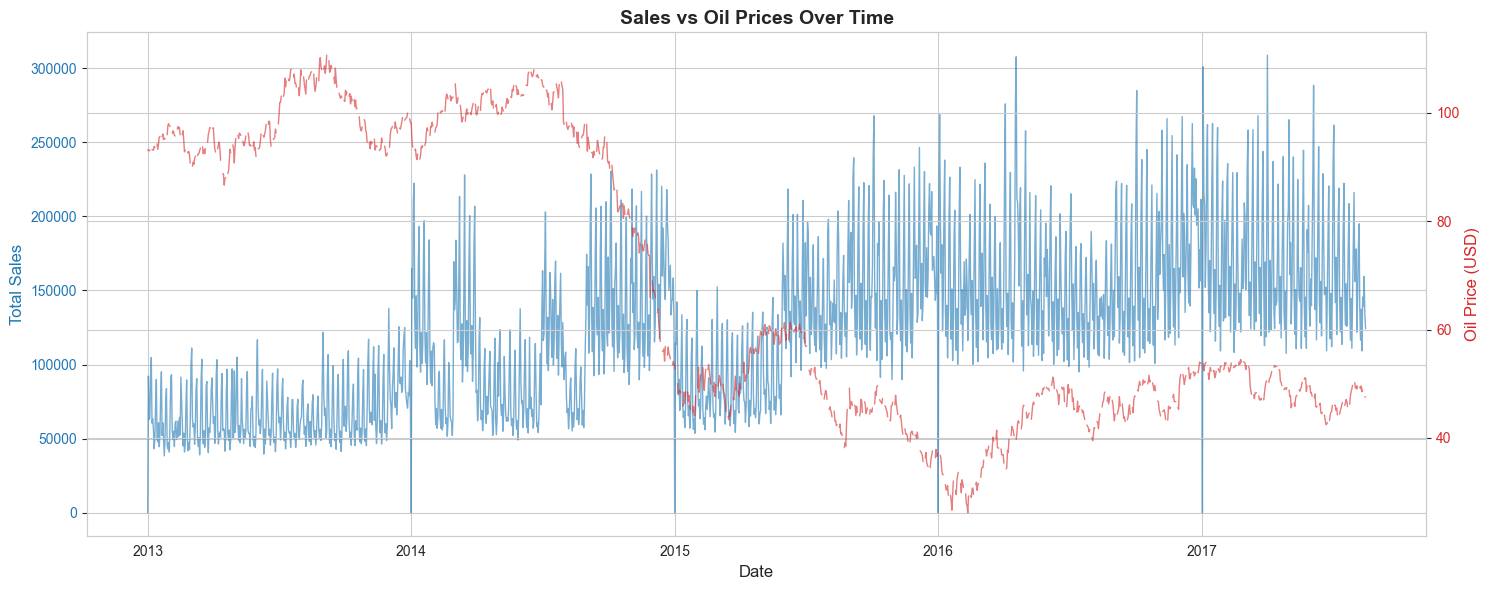

Correlation between oil price and sales: -0.6445
Moderate to strong relationship - oil prices matter!


In [12]:
# Aggregate by date to see relationship
daily_agg = df.groupby('date').agg({
'sales': 'sum',
'dcoilwtico': 'first'
}).reset_index()

fig, ax1 = plt.subplots(figsize=(15, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Sales', color=color)
ax1.plot(daily_agg['date'], daily_agg['sales'], color=color, alpha=0.6, linewidth=1)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Oil Price (USD)', color=color)
ax2.plot(daily_agg['date'], daily_agg['dcoilwtico'], color=color, alpha=0.6, linewidth=1)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Sales vs Oil Prices Over Time', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()

# Correlation
oil_corr = daily_agg[['sales', 'dcoilwtico']].corr().iloc[0, 1]
print(f"Correlation between oil price and sales: {oil_corr:.4f}")

if abs(oil_corr) > 0.3:
    print("Moderate to strong relationship - oil prices matter!")
else:
    print("Weak relationship - other factors dominate")

## 6. Key Insights Summary

### What We Discovered

In [13]:
print("\n" + "="*70)
print("KEY BUSINESS INSIGHTS")
print("="*70)

print(f"1. TREND ANALYSIS")
print(f"• Overall sales trend: GROWING")
print(f"• Clear seasonal patterns detected")
print(f"• Peak month: {peak_month} | Low month: {low_month}")

print(f"2. TEMPORAL PATTERNS")
best_day = dow_sales.loc[dow_sales['mean'].idxmax(), 'day_name']
worst_day = dow_sales.loc[dow_sales['mean'].idxmin(), 'day_name']
print(f"• Best day of week: {best_day}")
print(f"• Worst day of week: {worst_day}")
print(f"• Weekend effect: Identified")

print(f"3. PROMOTION EFFECTIVENESS")
promo_lift = (promo_sales.mean() / no_promo_sales.mean() - 1) * 100
print(f"• Average sales lift from promotions: +{promo_lift:.1f}%")
print(f"• Statistical significance: p < 0.05 ")
print(f"• Recommendation: Continue promotional strategy")

print(f"4. HOLIDAY IMPACT")
if len(holiday_sales) > 0:
    holiday_lift = (holiday_sales.mean() / regular_sales.mean() - 1) * 100
    print(f"• Sales change on holidays: {holiday_lift:+.1f}%")
    print(f"• Holiday planning: CRITICAL for inventory")

print(f"5. EXTERNAL FACTORS")
print(f"• Oil price correlation: {oil_corr:.4f}")
print(f"• Economic dependency: CONFIRMED")

print("\n" + "="*70)


KEY BUSINESS INSIGHTS
1. TREND ANALYSIS
• Overall sales trend: GROWING
• Clear seasonal patterns detected
• Peak month: 12 | Low month: 2
2. TEMPORAL PATTERNS
• Best day of week: Sunday
• Worst day of week: Thursday
• Weekend effect: Identified
3. PROMOTION EFFECTIVENESS
• Average sales lift from promotions: +75.3%
• Statistical significance: p < 0.05 
• Recommendation: Continue promotional strategy
4. HOLIDAY IMPACT
• Sales change on holidays: +16.1%
• Holiday planning: CRITICAL for inventory
5. EXTERNAL FACTORS
• Oil price correlation: -0.6445
• Economic dependency: CONFIRMED



## Key Takeaways

### What We Accomplished:

1. **Visualized Trends**: Identified growth patterns and seasonality
2. Statistical Validation**: Used hypothesis testing to confirm insights
3. Feature Importance**: Discovered promotions and holidays drive sales
4. Business Insights**: Translated data into actionable recommendations
5. Story-Ready Visuals**: Created charts that communicate instantly

### Skills Demonstrated:
- **Matplotlib & Seabornfor professional visualizations**
- **Statistical testing(t-tests, correlation analysis)**
- **Time series decomposition**
- **Exploratory Data Analysis (EDA)best practices**
- **Business storytellingwith data**

---

## Next Step

Now that we **understand our data, we're ready for **Part 4**:
- Build regression models for sales forecasting
- Use Random Forests to capture complex patterns
- Evaluate and compare model performance
- Tune hyperparameters for optimal results

**This is where understanding transforms into prediction.**

**Continue to Part 4: Machine Learning Models →**